In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
# import PIL

In [2]:
# import data
folder="./dataset"
# transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize((224, 224))])
data_train_val=torchvision.datasets.FashionMNIST(root=folder,train=True,download=True,transform=None)
data_test=torchvision.datasets.FashionMNIST(root=folder,train=False,download=True,transform=None)

In [3]:
classes=data_test.classes

In [4]:
# import matplotlib.pyplot as plt
# figure = plt.figure(figsize = (8,8))
# cols, rows = 4, 4
# ids=torch.randint(len(data_test), size = (cols*rows,))
# for i in range (1, cols*rows + 1):
#     image, label = data_test[ids[i-1].item()]
#     figure.add_subplot(rows, cols, i)
#     plt.title(classes[label])
#     plt.axis('off')
#     plt.imshow(image.squeeze(), cmap='gray')
#     # plt.imshow(image.squeeze())
# plt.show()

In [5]:
# data_train_val.data[:2000].shape
data_test.data.shape
# type(data_train_val.data)
# data_test.targets.shape

torch.Size([10000, 28, 28])

### Data Preparation (10 points)
- (a) Data cleansing and transformation (5 points)

In [6]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, trans=None):
        self.x = inputs
        self.y = targets
        self.trans=trans

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, idx):

        if self.trans == None:
            # print("no trans")
            return ( self.x[idx], self.y[idx])
        else:
            # print("trans")
            return ( self.trans(self.x[idx]), self.y[idx]) 

def ds_trans(ds_input,trans_flag):
    data_input=ds_input.data.clone().detach()
    labels_input=ds_input.targets
    if data_input.ndim <= 3:
        transform_train_val = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=(0,3), translate=(0,0.05), scale=None, shear=(0,0.05)),
            transforms.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)
        ])
    elif data_input.ndim == 4:
        # Should not come here
        print("WRONG!")

    if torch.isnan(data_input).any():
        print("have NaN or Inf")
    data_input = data_input[:,None,:,:]
    print(data_input.shape)
    
    if trans_flag==1:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_train_val)
    elif trans_flag==2:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_test)
    else:
        flag_ds_new = dataset(data_input, labels_input, trans=None)
    return (flag_ds_new)
    

In [7]:
torchvision.__version__

'0.16.0'

In [8]:
ds_processed_train_val=ds_trans(ds_input=data_train_val,trans_flag=1)
ds_processed_test=ds_trans(ds_input=data_test,trans_flag=2)
# ds_processed.x.shape

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


- (b) Data splitting (i.e., training, validation, and test splits) (5 points)

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler

random_seed=22
indices = list(range(data_train_val.targets.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)

indices_train=indices[:50000]
indices_val=indices[50000:]

ds_processed_train_sampler=SubsetRandomSampler(indices_train)
ds_processed_val_sampler=SubsetRandomSampler(indices_val)

# batch_size=64
batch_size=256
num_workers=10
loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                            num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                            num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [10]:
for batch_idx, (inputs, targets) in enumerate(loader_train):
    break
print(inputs.shape)
print(targets.shape)

torch.Size([256, 1, 64, 64])
torch.Size([256])


## Model

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def trainloop (dataloader, model, loss_fn, optimizer,device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')
            
def evaluate (dataloader, model, loss_fn,device):
    # size = len(dataloader.dataset)
    size = len(dataloader.sampler)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    Y_pred=[]
    Y_true=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            Y_pred.append(pred.argmax(1).cpu().numpy())
            Y_true.append(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    accuracy=100*correct
    Y_pred=np.concatenate(Y_pred)
    Y_true=np.concatenate(Y_true)
    accuracy2=accuracy_score(Y_true,Y_pred)
    # print(f'Accuracy2: {(accuracy2*100):>0.1f}')
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_pred)
    print("accuracy, precision, recall, f1, test_loss:")
    print(accuracy, precision, recall, f1, test_loss)
    return [accuracy, precision, recall, f1, test_loss], cm

In [12]:
# model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# model2.features[0]


In [13]:
import torchvision
def build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4
    epochs = 50

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # loss_fn = nn.MSELoss(reduction='sum')

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    

    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)

        if i%25==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Validation Dataset Error:");
            evaluate(loader_val, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    
    # Acc=np.zeros(3)
    # Loss=np.zeros(3)
    # print("Training Dataset Error:")
    # Acc[0],Loss[0]=evaluate(loader_train, model, loss_fn,device)
    # print("Validation Dataset Error:");
    # Acc[1],Loss[1]=evaluate(loader_val, model, loss_fn,device)
    # print("Test Dataset Error:");
    # Acc[2],Loss[2]=evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Validation Dataset Error:");
    result_val,cm_val=evaluate(loader_val, model, loss_fn,device)
    print("Test Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_val,result_test]

    return results,cm_val

In [14]:
def split_6_fold(index,ds_processed_train_val,ds_processed_test,indices):
    N=ds_processed_train_val.y.shape[0]
    nsub=int(N/6)
    # indices_train=indices[:50000]
    indices_train=[indices[i] for i in range(N) if i <index*nsub or i >=(index+1)*nsub]
    indices_val=indices[index*nsub:(index+1)*nsub]

    ds_processed_train_sampler=SubsetRandomSampler(indices_train)
    ds_processed_val_sampler=SubsetRandomSampler(indices_val)

    # batch_size=64
    batch_size=256
    num_workers=6
    loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                                num_workers=num_workers)
    loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                                num_workers=num_workers)
    loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)
    return  loader_train,loader_val,loader_test

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def one_iteration(learning_rate, id_optimizer,indices):
    # learning_rate=1e-4
    # id_optimizer=0
    ACC=[]
    LOSS=[]
    Results=[]
    CM_val=[]
    for i in range(6):
        print(f"Fold {i}\n-------------------------------")
        loader_train,loader_val,loader_test=split_6_fold(i,ds_processed_train_val,ds_processed_test,indices)
        results,cm_val=build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer)
        results=np.array(results)
        Results.append(results)
        CM_val.append(cm_val)
        torch.cuda.empty_cache() # test
    Results=np.array(Results) # dim0: i from 0-5; dim1: train, val, test; dim2: acc, precision, recall, f1 score, loss
    Results_ave=np.mean(Results,0) #dim0: train, val, test; dim1: acc, precision, recall, f1 score, loss
    try:
        CM_val_ave=np.mean(CM_val,0)
        CM_val_ave_percent=CM_val_ave/np.sum(CM_val_ave,
                                             axis=1,keepdims=True)

        # print("np.sum(CM_val_ave)=",np.sum(CM_val_ave)) # close to 10000. Wrong
        # ACC=Results_ave[:,0]
        # LOSS=Results_ave[:,4]
        # print("ACC:\nAve: ",np.mean(ACC,0),"std: ",np.std(ACC,0))
        # print("LOSS:\nAve: ",np.mean(LOSS,0),"std: ",np.std(LOSS,0))
        print("Results_ave: \nacc, precision, recall, f1 score, loss")
        print(Results_ave)
        print("Confusion Matrix: \n",CM_val_ave_percent)
        classes_id=['0','1','2','3','4','5','6','7','8','9']
        # print(classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=np.round(CM_val_ave_percent,2),
                                display_labels=classes_id)
        disp.plot()
        plt.show()
    except:
        print("Failed to plot.")

    return Results_ave

In [16]:
a=np.array([2,1,3])
b=np.array([1,2,3])
ab=[a,b]
ab=np.array(ab)

c=np.array([3.15154,2,4])
d=np.array([1,2,3])
cd=[c,d]
cd=np.array(cd)

abcd=[ab,cd]
abcd=np.array(abcd)
abcd
np.mean(abcd,0)

np.round(abcd,2)

array([[[2.  , 1.  , 3.  ],
        [1.  , 2.  , 3.  ]],

       [[3.15, 2.  , 4.  ],
        [1.  , 2.  , 3.  ]]])

id_optimizer: 0	learning_rate: 0.001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:14.802157 [    0/60000]
loss:0.905530 [25600/60000]
Training Dataset Error:
Accuracy: 78.1%, Avg loss: 0.585580 

accuracy, precision, recall, f1, test_loss:
78.11399999999999 0.780921687482693 0.7798614086419199 0.768802526112075 0.5855799683806847
Validation Dataset Error:
Accuracy: 77.2%, Avg loss: 0.586068 

accuracy, precision, recall, f1, test_loss:
77.25 0.777735058102105 0.7790637500630304 0.7660012957627466 0.5860683917999268
Test Dataset Error:
Accuracy: 77.4%, Avg loss: 0.603733 

accuracy, precision, recall, f1, test_loss:
77.37 0.7863126278039761 0.7737 0.7594107001149581 0.6037333585321903
Epoch 2
loss:0.691071 [    0/60000]
loss:0.487400 [25600/60000]
Epoch 3
loss:0.484487 [    0/60000]
loss:0.473576 [25600/60000]
Epoch 4
loss:0.491440 [    0/60000]
loss:0.413739 [25600/60000]
Epoch 5
loss:0.430038 [    0/

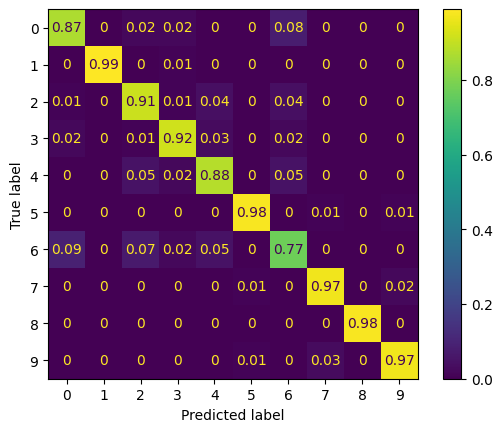

####################################################
id_optimizer: 0	learning_rate: 0.0001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:14.930888 [    0/60000]
loss:0.887422 [25600/60000]
Training Dataset Error:
Accuracy: 78.7%, Avg loss: 0.580985 

accuracy, precision, recall, f1, test_loss:
78.688 0.7830378019894033 0.7858281655346465 0.7823109728313764 0.5809849220879224
Validation Dataset Error:
Accuracy: 77.5%, Avg loss: 0.595322 

accuracy, precision, recall, f1, test_loss:
77.53999999999999 0.7752025549017387 0.7808445658084886 0.7762917330298362 0.5953215144574642
Test Dataset Error:
Accuracy: 79.4%, Avg loss: 0.582968 

accuracy, precision, recall, f1, test_loss:
79.4 0.791538358512462 0.794 0.7897753352973039 0.5829683847725391
Epoch 2
loss:0.719804 [    0/60000]
loss:0.459972 [25600/60000]
Epoch 3
loss:0.402038 [    0/60000]
loss:0.609069 [25600/60000]
Epoch 4
loss:0.389857 [    0/60000]
lo

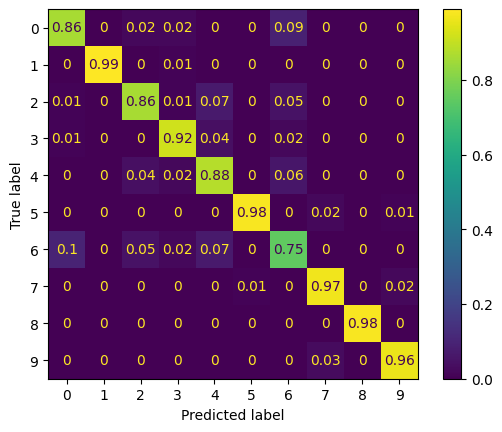

####################################################
id_optimizer: 0	learning_rate: 1e-05 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:17.134499 [    0/60000]
loss:4.161413 [25600/60000]
Training Dataset Error:
Accuracy: 44.8%, Avg loss: 1.627302 

accuracy, precision, recall, f1, test_loss:
44.775999999999996 0.257082488823349 0.2629164673089135 0.2583829694732747 1.6273023674682694
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 44.5%, Avg loss: 1.616563 

accuracy, precision, recall, f1, test_loss:
44.529999999999994 0.29158731917170916 0.2995494289919872 0.2932808621100917 1.616563442349434
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 43.3%, Avg loss: 1.603207 

accuracy, precision, recall, f1, test_loss:
43.29 0.32985988622886653 0.3330000000000001 0.328526555632913 1.6032073259353639
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.208227 [    0/60000]
loss:1.589704 [25600/60000]
Epoch 3
loss:1.276026 [    0/60000]
loss:1.131129 [25600/60000]
Epoch 4
loss:1.143492 [    0/60000]
loss:1.130204 [25600/60000]
Epoch 5
loss:0.941835 [    0/60000]
loss:0.881868 [25600/60000]
Epoch 6
loss:0.798649 [    0/60000]
loss:0.779476 [25600/60000]
Epoch 7
loss:0.863254 [    0/60000]
loss:0.803182 [25600/60000]
Epoch 8
loss:0.641452 [    0/60000]
loss:0.816794 [25600/60000]
Epoch 9
loss:0.745283 [    0/60000]
loss:0.724865 [25600/60000]
Epoch 10
loss:0.661578 [    0/60000]
loss:0.477192 [25600/60000]
Epoch 11
loss:0.675305 [    0/60000]
loss:0.651893 [25600/60000]
Epoch 12
loss:0.613335 [    0/60000]
loss:0.507610 [25600/60000]
Epoch 13
loss:0.532629 [    0/60000]
loss:0.632187 [25600/60000]
Epoch 14
loss:0.601864 [    0/60000]
loss:0.615559 [25600/60000]
Epoch 15
loss:0.528183 [    0/60000]
loss:0.569313 [25600/60000]
Epoch 16
loss:0.524693 [    0/60000]
loss:0.585371 [25600/60000]
Epoch 17
loss:0.470208 [    0/60000]
loss

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 47.7%, Avg loss: 1.632737 

accuracy, precision, recall, f1, test_loss:
47.67 0.2459902410974788 0.23809961857506529 0.23860837598914464 1.6327371805906297
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 46.7%, Avg loss: 1.626036 

accuracy, precision, recall, f1, test_loss:
46.69 0.23115254943310562 0.22233333333333336 0.22139536405908655 1.626035749912262
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.028547 [    0/60000]
loss:1.287874 [25600/60000]
Epoch 3
loss:1.176030 [    0/60000]
loss:1.254449 [25600/60000]
Epoch 4
loss:0.997006 [    0/60000]
loss:1.007442 [25600/60000]
Epoch 5
loss:0.835471 [    0/60000]
loss:0.865744 [25600/60000]
Epoch 6
loss:0.583362 [    0/60000]
loss:0.706068 [25600/60000]
Epoch 7
loss:0.722479 [    0/60000]
loss:0.699491 [25600/60000]
Epoch 8
loss:0.639048 [    0/60000]
loss:0.664996 [25600/60000]
Epoch 9
loss:0.599510 [    0/60000]
loss:0.732496 [25600/60000]
Epoch 10
loss:0.714919 [    0/60000]
loss:0.659706 [25600/60000]
Epoch 11
loss:0.656729 [    0/60000]
loss:0.610803 [25600/60000]
Epoch 12
loss:0.572949 [    0/60000]
loss:0.619862 [25600/60000]
Epoch 13
loss:0.554873 [    0/60000]
loss:0.609039 [25600/60000]
Epoch 14
loss:0.644610 [    0/60000]
loss:0.602107 [25600/60000]
Epoch 15
loss:0.617287 [    0/60000]
loss:0.471077 [25600/60000]
Epoch 16
loss:0.426359 [    0/60000]
loss:0.533032 [25600/60000]
Epoch 17
loss:0.478945 [    0/60000]
loss

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 56.7%, Avg loss: 1.324347 

accuracy, precision, recall, f1, test_loss:
56.66 0.3819482155186747 0.37677253055831544 0.37171941863831026 1.3243473500013352
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 58.2%, Avg loss: 1.285908 

accuracy, precision, recall, f1, test_loss:
58.19 0.42475329013912005 0.4156428571428572 0.4110264105292898 1.2859077244997024
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.842208 [    0/60000]
loss:1.551779 [25600/60000]
Epoch 3
loss:1.012054 [    0/60000]
loss:1.174715 [25600/60000]
Epoch 4
loss:0.999388 [    0/60000]
loss:0.936395 [25600/60000]
Epoch 5
loss:0.791247 [    0/60000]
loss:0.780295 [25600/60000]
Epoch 6
loss:0.780336 [    0/60000]
loss:0.775843 [25600/60000]
Epoch 7
loss:0.685117 [    0/60000]
loss:0.706975 [25600/60000]
Epoch 8
loss:0.615996 [    0/60000]
loss:0.758837 [25600/60000]
Epoch 9
loss:0.545298 [    0/60000]
loss:0.554614 [25600/60000]
Epoch 10
loss:0.624979 [    0/60000]
loss:0.709199 [25600/60000]
Epoch 11
loss:0.607692 [    0/60000]
loss:0.587337 [25600/60000]
Epoch 12
loss:0.600956 [    0/60000]
loss:0.594184 [25600/60000]
Epoch 13
loss:0.543874 [    0/60000]
loss:0.530402 [25600/60000]
Epoch 14
loss:0.536992 [    0/60000]
loss:0.531869 [25600/60000]
Epoch 15
loss:0.610359 [    0/60000]
loss:0.502551 [25600/60000]
Epoch 16
loss:0.565710 [    0/60000]
loss:0.404855 [25600/60000]
Epoch 17
loss:0.429361 [    0/60000]
loss

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 39.6%, Avg loss: 1.872068 

accuracy, precision, recall, f1, test_loss:
39.62 0.1742501952638473 0.16344443452269386 0.15902508964476517 1.8720680952072144
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 39.6%, Avg loss: 1.847283 

accuracy, precision, recall, f1, test_loss:
39.65 0.22348904585621593 0.22027777777777777 0.20975448250939188 1.8472826451063156
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.519091 [    0/60000]
loss:1.855508 [25600/60000]
Epoch 3
loss:1.391701 [    0/60000]
loss:1.041911 [25600/60000]
Epoch 4
loss:1.105810 [    0/60000]
loss:1.092220 [25600/60000]
Epoch 5
loss:0.878260 [    0/60000]
loss:0.807137 [25600/60000]
Epoch 6
loss:0.977310 [    0/60000]
loss:0.829311 [25600/60000]
Epoch 7
loss:0.872452 [    0/60000]
loss:0.644162 [25600/60000]
Epoch 8
loss:0.559993 [    0/60000]
loss:0.602201 [25600/60000]
Epoch 9
loss:0.716388 [    0/60000]
loss:0.701478 [25600/60000]
Epoch 10
loss:0.617861 [    0/60000]
loss:0.636333 [25600/60000]
Epoch 11
loss:0.551932 [    0/60000]
loss:0.582842 [25600/60000]
Epoch 12
loss:0.621814 [    0/60000]
loss:0.555305 [25600/60000]
Epoch 13
loss:0.639896 [    0/60000]
loss:0.548442 [25600/60000]
Epoch 14
loss:0.586557 [    0/60000]
loss:0.547002 [25600/60000]
Epoch 15
loss:0.595823 [    0/60000]
loss:0.647521 [25600/60000]
Epoch 16
loss:0.618696 [    0/60000]
loss:0.474001 [25600/60000]
Epoch 17
loss:0.516824 [    0/60000]
loss

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 45.8%, Avg loss: 1.736411 

accuracy, precision, recall, f1, test_loss:
45.76 0.26143793213432315 0.2685863117329144 0.25441566193305243 1.7364107251167298
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 46.4%, Avg loss: 1.757133 

accuracy, precision, recall, f1, test_loss:
46.39 0.26554200443538933 0.27288235294117646 0.2550519064021349 1.7571330338716507
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.257906 [    0/60000]
loss:1.672575 [25600/60000]
Epoch 3
loss:1.101781 [    0/60000]
loss:1.202904 [25600/60000]
Epoch 4
loss:1.140801 [    0/60000]
loss:0.904071 [25600/60000]
Epoch 5
loss:0.765275 [    0/60000]
loss:0.879936 [25600/60000]
Epoch 6
loss:0.775260 [    0/60000]
loss:0.762686 [25600/60000]
Epoch 7
loss:0.630465 [    0/60000]
loss:0.786693 [25600/60000]
Epoch 8
loss:0.761148 [    0/60000]
loss:0.556674 [25600/60000]
Epoch 9
loss:0.698454 [    0/60000]
loss:0.644498 [25600/60000]
Epoch 10
loss:0.710645 [    0/60000]
loss:0.732863 [25600/60000]
Epoch 11
loss:0.682992 [    0/60000]
loss:0.640276 [25600/60000]
Epoch 12
loss:0.580268 [    0/60000]
loss:0.620151 [25600/60000]
Epoch 13
loss:0.608559 [    0/60000]
loss:0.644257 [25600/60000]
Epoch 14
loss:0.474470 [    0/60000]
loss:0.528030 [25600/60000]
Epoch 15
loss:0.569005 [    0/60000]
loss:0.546058 [25600/60000]
Epoch 16
loss:0.531675 [    0/60000]
loss:0.493705 [25600/60000]
Epoch 17
loss:0.550474 [    0/60000]
loss

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 51.3%, Avg loss: 1.481839 

accuracy, precision, recall, f1, test_loss:
51.25999999999999 0.3254097968344877 0.31943553994922563 0.31987796013075687 1.481838631629944
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 48.2%, Avg loss: 1.501521 

accuracy, precision, recall, f1, test_loss:
48.24 0.35923162173611034 0.34457142857142864 0.34490272228968794 1.5015208691358566
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.061982 [    0/60000]
loss:1.503304 [25600/60000]
Epoch 3
loss:1.169781 [    0/60000]
loss:1.104207 [25600/60000]
Epoch 4
loss:0.986985 [    0/60000]
loss:0.949119 [25600/60000]
Epoch 5
loss:0.904328 [    0/60000]
loss:0.739993 [25600/60000]
Epoch 6
loss:0.800567 [    0/60000]
loss:0.764149 [25600/60000]
Epoch 7
loss:0.761107 [    0/60000]
loss:0.675520 [25600/60000]
Epoch 8
loss:0.586942 [    0/60000]
loss:0.703932 [25600/60000]
Epoch 9
loss:0.660182 [    0/60000]
loss:0.601687 [25600/60000]
Epoch 10
loss:0.565207 [    0/60000]
loss:0.658667 [25600/60000]
Epoch 11
loss:0.586384 [    0/60000]
loss:0.720449 [25600/60000]
Epoch 12
loss:0.599768 [    0/60000]
loss:0.619099 [25600/60000]
Epoch 13
loss:0.615901 [    0/60000]
loss:0.539380 [25600/60000]
Epoch 14
loss:0.626988 [    0/60000]
loss:0.644926 [25600/60000]
Epoch 15
loss:0.619665 [    0/60000]
loss:0.527717 [25600/60000]
Epoch 16
loss:0.546052 [    0/60000]
loss:0.547916 [25600/60000]
Epoch 17
loss:0.487510 [    0/60000]
loss

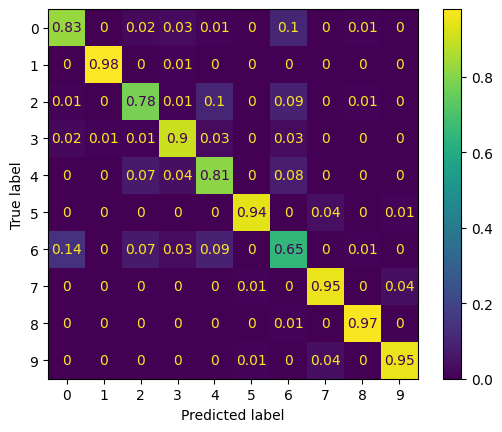

####################################################
id_optimizer: 1	learning_rate: 0.001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:16.284763 [    0/60000]
loss:2.587670 [25600/60000]
Training Dataset Error:
Accuracy: 43.1%, Avg loss: 1.460812 

accuracy, precision, recall, f1, test_loss:
43.122 0.4540348654065453 0.4296213203098202 0.37045059172527456 1.4608119695770496
Validation Dataset Error:
Accuracy: 41.9%, Avg loss: 1.479462 

accuracy, precision, recall, f1, test_loss:
41.9 0.4573955121013181 0.4269391158647785 0.36397747487704 1.479461696743965
Test Dataset Error:
Accuracy: 43.3%, Avg loss: 1.468390 

accuracy, precision, recall, f1, test_loss:
43.269999999999996 0.4488671358406216 0.4327 0.3776363018226352 1.4683904260396958
Epoch 2
loss:1.573531 [    0/60000]
loss:2.123037 [25600/60000]
Epoch 3
loss:0.802104 [    0/60000]
loss:0.864649 [25600/60000]
Epoch 4
loss:0.677904 [    0/60000]
lo

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 23.3%, Avg loss: 1.949676 

accuracy, precision, recall, f1, test_loss:
23.27 0.15594731233381168 0.2323172136901884 0.14458108283002563 1.9496756553649903
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 22.8%, Avg loss: 1.942903 

accuracy, precision, recall, f1, test_loss:
22.759999999999998 0.155632328849815 0.22759999999999997 0.1376868695349282 1.9429029524326324
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.943310 [    0/60000]
loss:0.914627 [25600/60000]
Epoch 3
loss:1.816427 [    0/60000]
loss:0.643339 [25600/60000]
Epoch 4
loss:0.818127 [    0/60000]
loss:0.589532 [25600/60000]
Epoch 5
loss:0.569105 [    0/60000]
loss:0.609310 [25600/60000]
Epoch 6
loss:2.551704 [    0/60000]
loss:0.657009 [25600/60000]
Epoch 7
loss:0.512059 [    0/60000]
loss:0.421336 [25600/60000]
Epoch 8
loss:0.468531 [    0/60000]
loss:0.382556 [25600/60000]
Epoch 9
loss:0.508224 [    0/60000]
loss:0.486952 [25600/60000]
Epoch 10
loss:0.488838 [    0/60000]
loss:0.374242 [25600/60000]
Epoch 11
loss:0.461823 [    0/60000]
loss:0.334997 [25600/60000]
Epoch 12
loss:0.446813 [    0/60000]
loss:0.308729 [25600/60000]
Epoch 13
loss:0.341153 [    0/60000]
loss:0.336836 [25600/60000]
Epoch 14
loss:0.395149 [    0/60000]
loss:0.280929 [25600/60000]
Epoch 15
loss:0.268597 [    0/60000]
loss:0.195612 [25600/60000]
Epoch 16
loss:0.413976 [    0/60000]
loss:0.263273 [25600/60000]
Epoch 17
loss:0.308357 [    0/60000]
loss

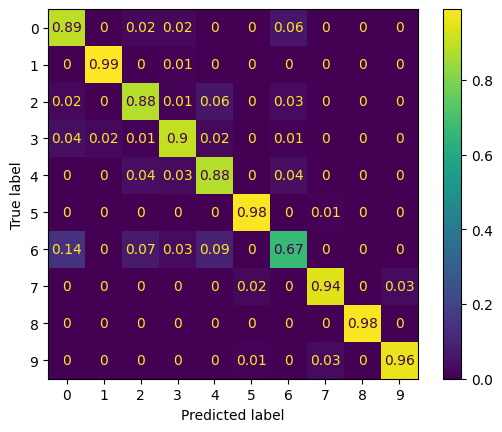

####################################################
id_optimizer: 1	learning_rate: 0.0001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:16.972223 [    0/60000]
loss:0.896522 [25600/60000]
Training Dataset Error:
Accuracy: 76.4%, Avg loss: 0.625868 

accuracy, precision, recall, f1, test_loss:
76.386 0.7728057176759716 0.762980462714229 0.7620272961985041 0.6258677256350614
Validation Dataset Error:
Accuracy: 76.1%, Avg loss: 0.625916 

accuracy, precision, recall, f1, test_loss:
76.07000000000001 0.7731388671191513 0.7652433104051422 0.7636989351501702 0.6259161055088043
Test Dataset Error:
Accuracy: 76.8%, Avg loss: 0.624750 

accuracy, precision, recall, f1, test_loss:
76.84 0.7835206679303987 0.7684000000000001 0.7662581469713522 0.6247501701116562
Epoch 2
loss:0.736808 [    0/60000]
loss:0.632435 [25600/60000]
Epoch 3
loss:0.660440 [    0/60000]
loss:0.558464 [25600/60000]
Epoch 4
loss:0.924890 [ 

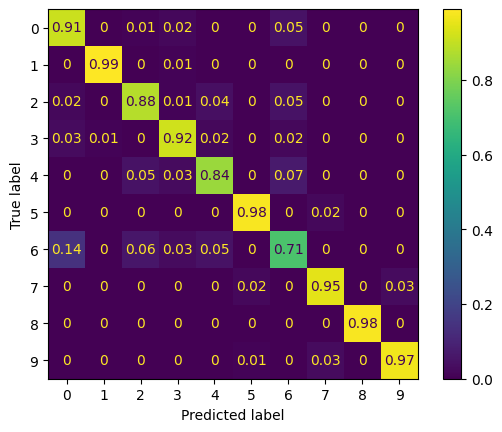

####################################################
id_optimizer: 1	learning_rate: 1e-05 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:16.123674 [    0/60000]
loss:1.838977 [25600/60000]
Training Dataset Error:
Accuracy: 64.7%, Avg loss: 1.067919 

accuracy, precision, recall, f1, test_loss:
64.714 0.6515027108811221 0.6460824730261263 0.6408272644044246 1.0679190350430352
Validation Dataset Error:
Accuracy: 64.1%, Avg loss: 1.076923 

accuracy, precision, recall, f1, test_loss:
64.11 0.5893911925335357 0.5876441028635067 0.5812288464232356 1.076923206448555
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 65.3%, Avg loss: 1.055597 

accuracy, precision, recall, f1, test_loss:
65.31 0.6588706540625489 0.6531 0.6416686015307332 1.0555973127484322
Epoch 2
loss:1.322890 [    0/60000]
loss:1.141107 [25600/60000]
Epoch 3
loss:1.116050 [    0/60000]
loss:0.869927 [25600/60000]
Epoch 4
loss:0.902296 [    0/60000]
loss:0.898694 [25600/60000]
Epoch 5
loss:0.773837 [    0/60000]
loss:0.745192 [25600/60000]
Epoch 6
loss:0.721859 [    0/60000]
loss:0.688256 [25600/60000]
Epoch 7
loss:0.709071 [    0/60000]
loss:0.719171 [25600/60000]
Epoch 8
loss:0.687113 [    0/60000]
loss:0.558763 [25600/60000]
Epoch 9
loss:0.651397 [    0/60000]
loss:0.707818 [25600/60000]
Epoch 10
loss:0.768240 [    0/60000]
loss:0.508843 [25600/60000]
Epoch 11
loss:0.674597 [    0/60000]
loss:0.681384 [25600/60000]
Epoch 12
loss:0.498822 [    0/60000]
loss:0.520623 [25600/60000]
Epoch 13
loss:0.406325 [    0/60000]
loss:0.528222 [25600/60000]
Epoch 14
loss:0.539338 [    0/60000]
loss:0.626369 [25600/60000]
Epoch 15
lo

: 

In [17]:
random_seed=22
indices = list(range(ds_processed_train_val.y.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)
Results_all=[]
for id_optimizer in [0,1]:
    # for learning_rate in [1e-3,1e-4,1e-5]:
    for learning_rate in [1e-2]:
        print(f"id_optimizer: {id_optimizer}\tlearning_rate: {learning_rate} \n-----------------------------------------------------------")
        Results_ave= one_iteration(learning_rate,id_optimizer,indices)
        Results_all.append([id_optimizer, learning_rate, Results_ave])
        print('####################################################')


In [ ]:
Results_all

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
